# Testing the Convergence Hypothesis

## Introduction

We provide an additional empirical example of partialling-out with Lasso to estimate the regression coefficient $\beta_1$ in the high-dimensional linear regression model:
  $$
  Y = \beta_1 D +  \beta_2'W + \epsilon.
  $$
  
Specifically, we are interested in how the rates  at which economies of different countries grow ($Y$) are related to the initial wealth levels in each country ($D$) controlling for country's institutional, educational, and other similar characteristics ($W$).
  
The relationship is captured by $\beta_1$, the *speed of convergence/divergence*, which measures the speed at which poor countries catch up $(\beta_1< 0)$ or fall behind $(\beta_1> 0)$ rich countries, after controlling for $W$. Our inference question here is: do poor countries grow faster than rich countries, controlling for educational and other characteristics? In other words, is the speed of convergence negative: $ \beta_1 <0?$ This is the Convergence Hypothesis predicted by the Solow Growth Model. This is a structural economic model. Under some strong assumptions, that we won't state here, the predictive exercise we are doing here can be given causal interpretation.


The outcome $Y$ is the realized annual growth rate of a country's wealth  (Gross Domestic Product per capita). The target regressor ($D$) is the initial level of the country's wealth. The target parameter $\beta_1$ is the speed of convergence, which measures the speed at which poor countries catch up with rich countries. The controls ($W$) include measures of education levels, quality of institutions, trade openness, and political stability in the country.

## Data analysis


We consider the data set GrowthData which is included in the package *hdm*. First, let us load the data set to get familiar with the data.

In [1]:
# import Pkg
# Pkg.add("RData")
# Pkg.add("CodecBzip2")
# Pkg.add("DataStructures")
# Pkg.add("NamedArrays")
# Pkg.add("PrettyTables")
# Pkg.add("Lasso")

In [58]:
using RData, LinearAlgebra, GLM, DataFrames, Statistics, Random, Distributions, DataStructures, NamedArrays, PrettyTables
import CodecBzip2

In [59]:
# Importing .Rdata file
growth_read = load("../../../data/GrowthData.RData")

Dict{String, Any} with 1 entry:
  "GrowthData" => 90×63 DataFrame…

In [60]:
# Since growth_read is a dictionary, we check if there is a key called "GrowthData", the one we need for our analyze
haskey(growth_read, "GrowthData")

true

In [61]:
# Now we save that dataframe with a new name
growth = growth_read["GrowthData"]
names(growth)

63-element Vector{String}:
 "Outcome"
 "intercept"
 "gdpsh465"
 "bmp1l"
 "freeop"
 "freetar"
 "h65"
 "hm65"
 "hf65"
 "p65"
 "pm65"
 "pf65"
 "s65"
 ⋮
 "secc65"
 "seccm65"
 "seccf65"
 "syr65"
 "syrm65"
 "syrf65"
 "teapri65"
 "teasec65"
 "ex1"
 "im1"
 "xr65"
 "tot1"

We determine the type and the dimension of our data set.

In [62]:
typeof(growth), size(growth)

(DataFrame, (90, 63))

The sample contains $90$ countries and $63$ controls. Thus $p \approx 60$, $n=90$ and $p/n$ is not small. We expect the least squares method to provide a poor estimate of $\beta_1$.  We expect the method based on partialling-out with Lasso to provide a high quality estimate of $\beta_1$.

To check this hypothesis, we analyze the relation between the output variable $Y$ and the other country's characteristics by running a linear regression in the first step.

In [63]:
y = growth[!, "Outcome"]
y = DataFrame([y], [:y])

,y
,Float64
1,-0.0243358
2,0.100473
3,0.0670515
4,0.0640892
5,0.0279295
6,0.0464074
7,0.0673323
8,0.0209777
9,0.0335512


In [64]:
X = select(growth, Not(["Outcome"]))

,intercept,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65
,Int32,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,6.59167,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29
2,1,6.82979,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91
3,1,8.89508,0.0,0.204244,0.009186,0.26,0.325,0.201,1.0
4,1,7.56528,0.1997,0.248714,0.03627,0.061,0.07,0.051,1.0
5,1,7.1624,0.174,0.299252,0.037367,0.017,0.027,0.007,0.82
6,1,7.21891,0.0,0.258865,0.02088,0.023,0.038,0.006,0.5
7,1,7.8536,0.0,0.182525,0.014385,0.039,0.063,0.014,0.92
8,1,7.70391,0.2776,0.215275,0.029713,0.024,0.035,0.013,0.69
9,1,9.06346,0.0,0.109614,0.002171,0.402,0.488,0.314,1.0


In [65]:
size(X)

(90, 62)

In [66]:
typeof(y), typeof(X)

(DataFrame, DataFrame)

In [67]:
data = [y X]

,y,intercept,gdpsh465,bmp1l,freeop,freetar,h65,hm65
,Float64,Int32,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.0243358,1,6.59167,0.2837,0.153491,0.043888,0.007,0.013
2,0.100473,1,6.82979,0.6141,0.313509,0.061827,0.019,0.032
3,0.0670515,1,8.89508,0.0,0.204244,0.009186,0.26,0.325
4,0.0640892,1,7.56528,0.1997,0.248714,0.03627,0.061,0.07
5,0.0279295,1,7.1624,0.174,0.299252,0.037367,0.017,0.027
6,0.0464074,1,7.21891,0.0,0.258865,0.02088,0.023,0.038
7,0.0673323,1,7.8536,0.0,0.182525,0.014385,0.039,0.063
8,0.0209777,1,7.70391,0.2776,0.215275,0.029713,0.024,0.035
9,0.0335512,1,9.06346,0.0,0.109614,0.002171,0.402,0.488


In [68]:
# OLS regression
reg_ols  = lm(term(:y) ~ sum(term.(names(data[!, Not(["y", "intercept"])]))), data, dropcollinear=false)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + gdpsh465 + bmp1l + freeop + freetar + h65 + hm65 + hf65 + p65 + pm65 + pf65 + s65 + sm65 + sf65 + fert65 + mort65 + lifee065 + gpop1 + fert1 + mort1 + invsh41 + geetot1 + geerec1 + gde1 + govwb1 + govsh41 + gvxdxe41 + high65 + highm65 + highf65 + highc65 + highcm65 + highcf65 + human65 + humanm65 + humanf65 + hyr65 + hyrm65 + hyrf65 + no65 + nom65 + nof65 + pinstab1 + pop65 + worker65 + pop1565 + pop6565 + sec65 + secm65 + secf65 + secc65 + seccm65 + seccf65 + syr65 + syrm65 + syrf65 + teapri65 + teasec65 + ex1 + im1 + xr65 + tot1

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                    Coef.    Std. Error      t  Pr(>|t|)      Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)   0.247161   

In [69]:
# output: estimated regression coefficient corresponding to the target regressor
est_ols = coef(reg_ols)[2]

# output: std. error
std_ols = stderror(reg_ols)[2]

# output: 95% confidence interval
lower_ci = coeftable(reg_ols).cols[5][2]
upper_ci = coeftable(reg_ols).cols[6][2]

0.05184424349589355

## Summarize OLS results

In [70]:
table_1 = NamedArray(zeros(1, 4))
setnames!(table_1, ["OLS"], 1)
table_1

1×4 Named Matrix{Float64}
A ╲ B │   1    2    3    4
──────┼───────────────────
OLS   │ 0.0  0.0  0.0  0.0

In [71]:
table_1[1] = est_ols
table_1[2] = std_ols   
table_1[3] = lower_ci
table_1[4] = upper_ci    
 
table_1

1×4 Named Matrix{Float64}
A ╲ B │           1            2            3            4
──────┼───────────────────────────────────────────────────
OLS   │ -0.00937799    0.0298877   -0.0706002    0.0518442

In [72]:
table_1_pandas = DataFrame( table_1, [ :"Estimator", :"Std. Error", :"lower bound CI", :"upper bound CI"])
model_1 = DataFrame(model = ["OLS"])
table_1_pandas = hcat(model_1,table_1_pandas)
table_1_pandas

,model,Estimator,Std. Error,lower bound CI,upper bound CI
,String,Float64,Float64,Float64,Float64
1,OLS,-0.00937799,0.0298877,-0.0706002,0.0518442


In [73]:
header = (["Model", "Estimator", "Std. Error", "lower bound CI", "upper bound CI"])
pretty_table(table_1_pandas; backend = Val(:html), header = header, formatters=ft_round(6), alignment=:c)

Model,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,-0.009378,0.029888,-0.0706,0.051844


Least squares provides a rather noisy estimate (high standard error) of the
speed of convergence, and does not allow us to answer the question
about the convergence hypothesis since the confidence interval includes zero.

In contrast, we can use the partialling-out approach based on lasso regression ("Double Lasso").

In [74]:
# Importing .Rdata file
growth_read = load("../../../data/GrowthData.RData")
# Now we save that dataframe with a new name
growth = growth_read["GrowthData"]

# Create main variables
Y = growth[!, "Outcome"]
Y = DataFrame([Y], [:Y])
D = growth[!, "gdpsh465"]
D = DataFrame([D], [:D])
W = select(growth, Not(["Outcome", "intercept", "gdpsh465"]))
data = [Y D W]

,Y,D,bmp1l,freeop,freetar,h65,hm65,hf65,p65
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.0243358,6.59167,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29
2,0.100473,6.82979,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91
3,0.0670515,8.89508,0.0,0.204244,0.009186,0.26,0.325,0.201,1.0
4,0.0640892,7.56528,0.1997,0.248714,0.03627,0.061,0.07,0.051,1.0
5,0.0279295,7.1624,0.174,0.299252,0.037367,0.017,0.027,0.007,0.82
6,0.0464074,7.21891,0.0,0.258865,0.02088,0.023,0.038,0.006,0.5
7,0.0673323,7.8536,0.0,0.182525,0.014385,0.039,0.063,0.014,0.92
8,0.0209777,7.70391,0.2776,0.215275,0.029713,0.024,0.035,0.013,0.69
9,0.0335512,9.06346,0.0,0.109614,0.002171,0.402,0.488,0.314,1.0


## Method 1 - Using Lasso

In [75]:
using Lasso, GLM

In [76]:
# Seat values for Lasso

lasso_model = fit(LassoModel, term(:Y) ~  sum(term.(names(data[!, Not(["Y", "D"])]))), data; α = 0.8)
r_Y = residuals(lasso_model)
r_Y = DataFrame([r_Y], [:r_Y])

# Part. out d

lasso_model = fit(LassoModel, term(:D) ~  sum(term.(names(data[!, Not(["Y", "D"])]))), data;  α = 0.8)
r_D = residuals(lasso_model)
r_D = DataFrame([r_D], [:r_D])

# ols 
data_aux = [r_Y r_D]
fm_1 = @formula(r_Y ~ r_D)
partial_lasso_fit = lm(fm_1, data_aux)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

r_Y ~ 1 + r_D

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)  -2.96067e-18  0.00417979  -0.00    1.0000  -0.00830646   0.00830646
r_D          -0.0500007    0.0152165   -3.29    0.0015  -0.0802403   -0.0197611
────────────────────────────────────────────────────────────────────────────────

In [77]:
# output: estimated regression coefficient corresponding to the target regressor
est_lasso = coef(partial_lasso_fit)[2]

# output: std. error
std_lasso = stderror(partial_lasso_fit)[2]

# output: 95% confidence interval
lower_ci_lasso = coeftable(partial_lasso_fit).cols[5][2]
upper_ci_lasso = coeftable(partial_lasso_fit).cols[6][2]

-0.01976108418900318

In [78]:
# Regress residuales
partial_lasso_fit = lm(fm_1, data_aux)
partial_lasso_est = coef(partial_lasso_fit)[2]

println("Coefficient for D via partialling-out using lasso is: ", partial_lasso_est )

Coefficient for D via partialling-out using lasso is: -0.050000699175125084


## Summary LASSO results


Finally, let us have a look at the results.

In [79]:
table_2 = NamedArray(zeros(1, 4))
setnames!(table_2, ["DOUBLE LASSO"], 1)
table_2

1×4 Named Matrix{Float64}
       A ╲ B │   1    2    3    4
─────────────┼───────────────────
DOUBLE LASSO │ 0.0  0.0  0.0  0.0

In [80]:
table_2[1] = est_lasso
table_2[2] = std_lasso   
table_2[3] = lower_ci_lasso
table_2[4] = upper_ci_lasso    
 
table_2

1×4 Named Matrix{Float64}
       A ╲ B │          1           2           3           4
─────────────┼───────────────────────────────────────────────
DOUBLE LASSO │ -0.0500007   0.0152165  -0.0802403  -0.0197611

In [81]:
table_2_pandas = DataFrame( table_2, [ :"Estimator", :"Std. Error", :"lower bound CI", :"upper bound CI"])
model_2 = DataFrame(model = ["DOUBLE LASSO"])
table_2_pandas = hcat(model_2,table_2_pandas)
table_2_pandas

,model,Estimator,Std. Error,lower bound CI,upper bound CI
,String,Float64,Float64,Float64,Float64
1,DOUBLE LASSO,-0.0500007,0.0152165,-0.0802403,-0.0197611


In [82]:
header = (["Model", "Estimator", "Std. Error", "lower bound CI", "upper bound CI"])
pretty_table(table_2_pandas; backend = Val(:html), header = header, formatters=ft_round(6), alignment=:c)

Model,Estimator,Std. Error,lower bound CI,upper bound CI
DOUBLE LASSO,-0.050001,0.015217,-0.08024,-0.019761


In [83]:
table_3 = vcat(table_1, table_2)
setnames!(table_3, ["OLS", "DOUBLE LASSO"], 1)
table_3

2×4 Named Matrix{Float64}
    vcat ╲ B │           1            2            3            4
─────────────┼───────────────────────────────────────────────────
OLS          │ -0.00937799    0.0298877   -0.0706002    0.0518442
DOUBLE LASSO │  -0.0500007    0.0152165   -0.0802403   -0.0197611

In [84]:
table_3_pandas = DataFrame( table_3, [ :"Estimator", :"Std. Error", :"lower bound CI", :"upper bound CI"])
model_3 = DataFrame(model = ["OLS", "DOUBLE LASSO"])
table_3_pandas = hcat(model_3, table_3_pandas)
table_3_pandas

,model,Estimator,Std. Error,lower bound CI,upper bound CI
,String,Float64,Float64,Float64,Float64
1,OLS,-0.00937799,0.0298877,-0.0706002,0.0518442
2,DOUBLE LASSO,-0.0500007,0.0152165,-0.0802403,-0.0197611


In [85]:
header = (["Model", "Estimator", "Std. Error", "lower bound CI", "upper bound CI"])
pretty_table(table_3_pandas; backend = Val(:html), header = header, formatters=ft_round(6), alignment=:c)

Model,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,-0.009378,0.029888,-0.0706,0.051844
DOUBLE LASSO,-0.050001,0.015217,-0.08024,-0.019761


The least square method provides a rather noisy estimate of the speed of convergence. We can not answer the question if poor countries grow faster than rich countries. The least square method does not work when the ratio $p/n$ is large.

In sharp contrast, partialling-out via Lasso provides a more precise estimate. The Lasso based point estimate is $-5\%$ and the $95\%$ confidence interval for the (annual) rate of convergence $[-8\%,-1.9\%]$ only includes negative numbers. This empirical evidence does support the convergence hypothesis.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Estimator</th>
      <th>Std. Error</th>
      <th>lower bound CI</th>
      <th>upper bound CI</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>OLS</th>
      <td>-0.009378</td>
      <td>0.029888</td>
      <td>-0.070600</td>
      <td>0.051844</td>
    </tr>
    <tr>
      <th>DOUBLE LASSO</th>
      <td>-0.050001</td>
      <td>0.015217</td>
      <td>-0.08024</td>
      <td>-0.019761</td>
    </tr>
  </tbody>
</table>

In [86]:
using Plots

In [87]:
xerror = table_3_pandas[!,2] .- table_3_pandas[!,4]

2-element Named Vector{Float64}
vcat         │ 
─────────────┼──────────
OLS          │ 0.0612222
DOUBLE LASSO │ 0.0302396

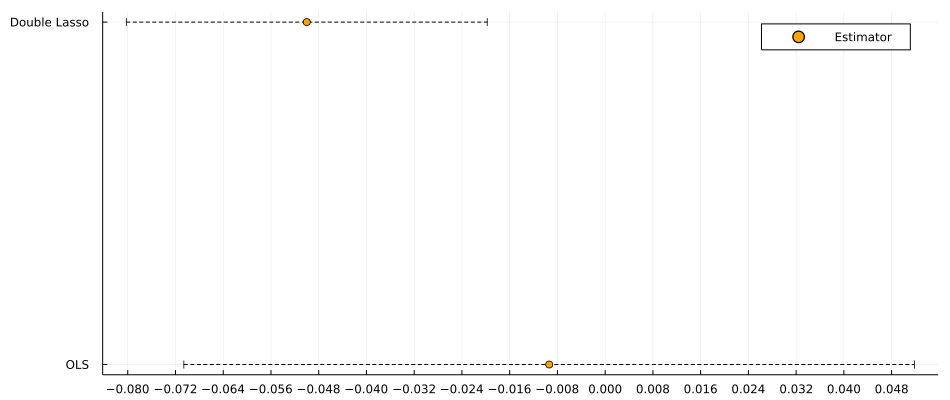

In [88]:
scatter(table_3_pandas[!,2], ["OLS", "Double Lasso"], label = "Estimator", xerrors = xerror, 
        xtick = -1:0.008:1, linestyle = :dash, seriescolor=:orange)
plot!(size=(950,400))

# Using HDMJL

### First we need to call hdmjl.jl script to use all the functions, mainly rlasso function

In [89]:
include("../hdmjl/hdmjl.jl")

### You use the **rlasso_arg** to declare the parameters that we use and the matrixes need.  You only need to change the first two arguments! 

In [90]:
res_Y_0 = rlasso_arg( W, Y, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

rlasso_arg(90×60 DataFrame
 Row │ bmp1l    freeop    freetar   h65      hm65     hf65     p65      pm65   ⋯
     │ Float64  Float64   Float64   Float64  Float64  Float64  Float64  Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  0.2837  0.153491  0.043888    0.007    0.013    0.001     0.29     0.3 ⋯
   2 │  0.6141  0.313509  0.061827    0.019    0.032    0.007     0.91     1.0
   3 │  0.0     0.204244  0.009186    0.26     0.325    0.201     1.0      1.0
   4 │  0.1997  0.248714  0.03627     0.061    0.07     0.051     1.0      1.0
   5 │  0.174   0.299252  0.037367    0.017    0.027    0.007     0.82     0.8 ⋯
   6 │  0.0     0.258865  0.02088     0.023    0.038    0.006     0.5      0.5
   7 │  0.0     0.182525  0.014385    0.039    0.063    0.014     0.92     0.9
   8 │  0.2776  0.215275  0.029713    0.024    0.035    0.013     0.69     0.6
   9 │  0.0     0.109614  0.002171    0.402    0.488    0.314     1.0      1.0 ⋯
  10 │  0.148

### Then we need to use the rlasso function including the arguments declared above 

In [91]:
res_Y = rlasso(res_Y_0)

Dict{String, Any} with 19 entries:
  "tss"          => 0.23435
  "dev"          => [-0.0696852, 0.0551231, 0.021702, 0.0187397, -0.0174199, 0.…
  "model"        => [0.114953 -0.0666109 … -42.3159 -0.023963; 0.445353 0.09340…
  "loadings"     => [0.0105688 0.00313556 … 6.58751 0.00342864]
  "sigma"        => [0.0477366]
  "lambda0"      => 74.3078
  "lambda"       => 60×2 DataFrame…
  "intercept"    => 0.0581009
  "Xy"           => [-0.417365, 0.0764848, -0.0198564, -0.0288688, -0.00603343,…
  "iter"         => 4
  "residuals"    => [-0.0609987, 0.0887764, 0.00895057, 0.0210787, -0.017023, -…
  "rss"          => 0.23435
  "index"        => Bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, …
  "beta"         => 60×2 DataFrame…
  "options"      => Dict{String, Any}("intercept"=>true, "post"=>true, "meanx"=…
  "x1"           => [0.114953; 0.445353; … ; -0.168747; -0.168747;;]
  "pen"          => Dict{String, Any}("lambda0"=>74.3078, "lambda"=>[0.786932; …
  "startingval"  => [-0.0

### The output is a dictionary, so you can access using the main keys. In our case we need the residuals

In [92]:
res_Y = res_Y["residuals"]

90-element Vector{Float64}:
 -0.06099874009956701
  0.08877641223870311
  0.008950566442299697
  0.021078676644940578
 -0.017022974171323174
 -0.011693476557700297
  0.009231424442299706
 -0.01614625852288254
 -0.0245496795577003
 -0.007740475439663712
  0.02026232962756845
  0.08610442802511419
 -0.04979783062530005
  ⋮
  0.04302905133674367
  0.007127644442299706
 -0.0200058925577003
 -0.0238879135577003
 -0.002598750661576797
 -0.019685277557700297
 -0.0262061255577003
 -0.0269049305577003
 -0.023627432161540035
 -0.011200453557700302
 -0.018327543557700297
 -0.0174593775577003

### We do the same for the second equation

In [93]:
res_D_0 = rlasso_arg( W, D, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
res_D = rlasso(res_D_0)["residuals"]
# We need to convert the vector into matrix because the lm function requires "X" to be matrix 
res_D = reshape(res_D, length(res_D), 1)

90×1 Matrix{Float64}:
  0.5222476356191383
  0.13027816139145787
  0.07232102747813007
 -0.13196899833674824
  0.09840468850707951
  0.35730568468428503
  0.2940976463777745
  0.7977842044326772
 -0.012818468998378796
  0.0894831204466463
  0.2479204691420016
 -0.15386797901857718
  0.519165734469782
  ⋮
  0.3977750029233086
 -0.21166662271143571
  0.32571865064338956
  0.18176367161336326
 -0.3787033106715221
 -0.30497902649692843
 -0.11113678995670373
  0.11492064458763807
 -0.08623958408114252
 -0.013143270340858715
  0.08676507620589669
  0.08653048463271396

### Regress errors 

In [94]:
reg3 = lm(res_D, res_Y)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────────
         Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────
x1  -0.0498115   0.0138578  -3.59    0.0005  -0.0773467  -0.0222762
───────────────────────────────────────────────────────────────────


### Summary models 

In [95]:
# output: estimated regression coefficient corresponding to the target regressor
est_lasso_hdm = coef(reg3)[1]

# output: std. error
std_lasso_hdm = stderror(reg3)[1]

# output: 95% confidence interval
lower_ci_lasso_hdm = coeftable(reg3).cols[5][1]
upper_ci_lasso_hdm = coeftable(reg3).cols[6][1]

-0.02227622624159959

In [96]:
table4 = NamedArray(zeros(1, 4))
setnames!(table4, ["DOUBLE LASSO (HDM)"], 1)

table4[1] = est_lasso_hdm
table4[2] = std_lasso_hdm   
table4[3] = lower_ci_lasso_hdm
table4[4] = upper_ci_lasso_hdm   

-0.02227622624159959

In [97]:
summary_table = vcat(table_3, table4)

3×4 Named Matrix{Float64}
vcat ╲ B │           1            2            3            4
─────────┼───────────────────────────────────────────────────
1        │ -0.00937799    0.0298877   -0.0706002    0.0518442
2        │  -0.0500007    0.0152165   -0.0802403   -0.0197611
3        │  -0.0498115    0.0138578   -0.0773467   -0.0222762

In [98]:
summary_table_pandas = DataFrame( summary_table, [ :"Estimator", :"Std. Error", :"lower bound CI", :"upper bound CI"])
model_names = DataFrame(model = ["OLS", "DOUBLE LASSO","DOUBLE LASSO HDM"])
summary_table_pandas = hcat(model_names, summary_table_pandas)
summary_table_pandas

,model,Estimator,Std. Error,lower bound CI,upper bound CI
,String,Float64,Float64,Float64,Float64
1,OLS,-0.00937799,0.0298877,-0.0706002,0.0518442
2,DOUBLE LASSO,-0.0500007,0.0152165,-0.0802403,-0.0197611
3,DOUBLE LASSO HDM,-0.0498115,0.0138578,-0.0773467,-0.0222762


In [99]:
header = (["Model", "Estimator", "Std. Error", "lower bound CI", "upper bound CI"])
pretty_table(summary_table_pandas; backend = Val(:html), header = header, formatters=ft_round(6), alignment=:c)

Model,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,-0.009378,0.029888,-0.0706,0.051844
DOUBLE LASSO,-0.050001,0.015217,-0.08024,-0.019761
DOUBLE LASSO HDM,-0.049811,0.013858,-0.077347,-0.022276


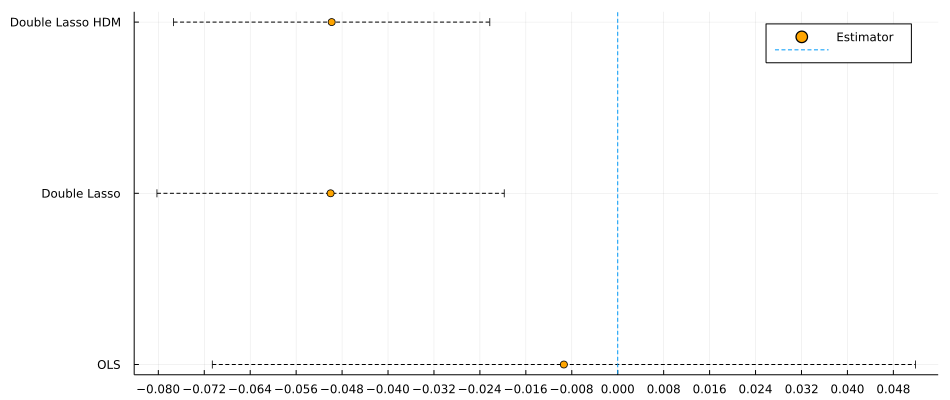

In [100]:
xerror = summary_table_pandas[!,2] .- summary_table_pandas[!,4]
scatter(summary_table_pandas[!,2], ["OLS", "Double Lasso", "Double Lasso HDM"], label = "Estimator", xerrors = xerror, 
        xtick = -1:0.008:1, linestyle = :dash, seriescolor=:orange)
plot!(size=(950,400))
plot!([0], seriestype="vline", linestyle = :dash, color = 1, label = " ")

In [103]:
import Pkg

Pkg.status("DataFrames")



      Status `C:\Users\Roberto\.julia\environments\v1.7\Project.toml`
  [a93c6f00] DataFrames v1.3.3
